In [1]:
import re
import numpy as np
import math
from matplotlib.patches import Polygon
import functools
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [2]:

%matplotlib inline

plt.rcParams['figure.figsize'] = [7,3]
plt.rcParams['axes.titlesize'] = "xx-large"
sns.set(font_scale = 1)
plt.rcParams["errorbar.capsize"] = 0.35

sns.set_style("whitegrid")

In [3]:
#Load the data
import pickle
with open("../data/deduped_policy_text_v11.pickle", "rb") as f:
    deduped_df = pickle.load(f)

In [4]:
df = deduped_df

# Rank binned stats

In [12]:
def get_bin(rank):
    if rank is None or math.isnan(rank):
        return "> 1M"
    elif rank >= 100000:
        return "[100k,1M)"
    elif rank >= 10000:
        return "[10k,100k)"
    elif rank >= 1000:
        return "[1k,10k)"
    else:
        return "[1,1k)"
        
df["rank_bin"] = df.alexa_rank.map(get_bin)

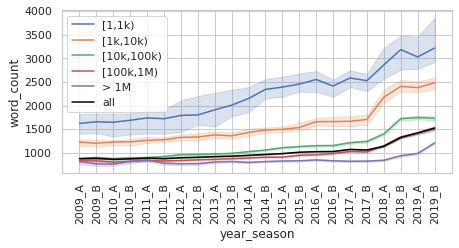

In [13]:
BIN_ORDER = ["[1,1k)","[1k,10k)","[10k,100k)","[100k,1M)","> 1M"]
sns.lineplot(x="year_season",y="word_count",hue="rank_bin",hue_order=BIN_ORDER,data=df[df.year>=2009].sort_values("year_season"),estimator=np.median)
sns.lineplot(x="year_season",y="word_count",data=deduped_df[deduped_df.year>=2009].sort_values("year_season"),label="all",color="black",estimator=np.median)
_ = plt.xticks(rotation=90)

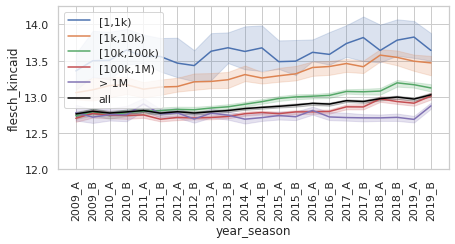

In [17]:
BIN_ORDER = ["[1,1k)","[1k,10k)","[10k,100k)","[100k,1M)","> 1M"]
sns.lineplot(x="year_season",y="flesch_kincaid",hue="rank_bin",hue_order=BIN_ORDER,data=df[(df.year>=2009) & df.flesch_kincaid.notnull()].sort_values("year_season"),estimator=np.median)
sns.lineplot(x="year_season",y="flesch_kincaid",data=df[(df.year>=2009) & df.flesch_kincaid.notnull()].sort_values("year_season"),label="all",color="black",estimator=np.median)

plt.ylim(12,14.25)

_ = plt.xticks(rotation=90)

In [16]:
df.flesch_kincaid

237698           NaN
1043500    14.697362
892937     12.654210
1118180    11.494614
337273     13.189422
             ...    
1221991    14.756003
340360     12.637166
892528     14.855711
79317      14.345425
547901     14.805873
Name: flesch_kincaid, Length: 910546, dtype: float64

# Setup

In [32]:
sample = df.sample(1000)

In [6]:
df["yearseason"] = df.apply(lambda row: "%d%s" % (row.year,row.season),axis=1)

In [7]:
#Get all intervals
def get_intervals(df):
    intervals = set(((y,s) for y,s in zip(df.year,df.season)))
    intervals = sorted(list(intervals)) #This will correctly sort due to Python's tuple handling behavior
    return intervals
    

In [8]:
#General plot things

intervals = get_intervals(df)
x = list(range(len(intervals)))
labels = ["%d%s" % interval for interval in intervals]

In [36]:
def present_for_desired_intervals(df,site_url,intervals):
    hits = 0
    for i,row in df[df.site_url == site_url].iterrows():
        if (row.year,row.season) in intervals:
            hits += 1
    return hits == len(intervals)

site_urls = list(set(df.site_url))

persist_intervals = list(filter(lambda interval: interval[0] >= 2010, intervals))
persistent_site_urls = set((site_url for site_url,site_df in df.groupby("site_url") if present_for_desired_intervals(site_df,site_url,persist_intervals)))

In [37]:
persistent_site_urls = set(persistent_site_urls)

def filter_persistent_sites(row):
    if row.site_url in persistent_site_urls and (row.year,row.season) in persist_intervals:
        return True
    return False

    
df_persistent = df[df.apply(filter_persistent_sites,axis=1)]

In [38]:
len(set(df_persistent.site_url))

1192

In [39]:
df.sort_values("word_count")[["word_count","site_url","yearseason"]]

,word_count,site_url,yearseason
143544,28,http://realblackfatties.com,2011A
187278,28,http://girlsfuckeachother.com,2019A
143543,28,http://realblackfatties.com,2009A
147679,28,http://lesanal.com,2015A
143547,28,http://realblackfatties.com,2012A
...,...,...,...
1001984,34645,http://forzamotorsport.net,2019B
617663,34645,http://seaofthieves.com,2019B
843367,34645,http://live.com,2019B
960913,34645,http://gearsofwar.com,2019B


In [40]:
df.word_count[(df.yearseason == "2016A")].median(), df.word_count[(df.yearseason == "2018B")].median()

(1025.0, 1325.0)

In [41]:
df.word_count[(df.year == 2009) & (df.alexa_rank <= 75)].median(), df.word_count[(df.yearseason == "2018B") & (df.alexa_rank <= 75)].median()

(2398.0, 4817.0)

# Number of Policies

In [42]:
def get_policy_count(df,y,s):
    ysdf = df[(df["year"]==y) & (df["season"]==s)]
    texts = ysdf.policy_text
    return len(texts)

In [43]:
def even_vals(it):
    return [v for i,v in enumerate(it) if i % 2 == 0]

def plot_policy_counts(df):
    intervals = get_intervals(df)
    x = list(range(len(intervals)))
    labels = ["%d" % year for year in sorted(set(list(zip(*intervals))[0]))]
    counts = [len(df[(df.year==y) & (df.season==s)]) for y,s in intervals]
    
    fig, ax = plt.subplots()


    chart = sns.barplot(x, counts, label="Average word count", color="steelblue")
    chart.set(ylabel="Number of policies")
    
    plt.xticks(np.arange(0,len(intervals),2)+0.5,labels,rotation="vertical")
    plt.title("Number of policies per interval")

    plt.savefig("figures/policy_counts.pdf",bbox_inches='tight')
    plt.show()

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


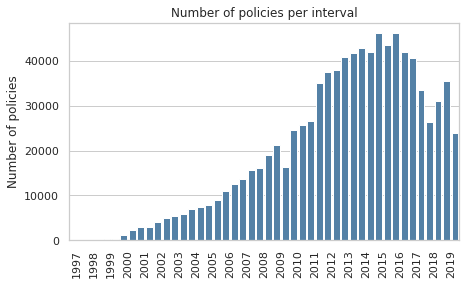

In [44]:
plot_policy_counts(df)

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


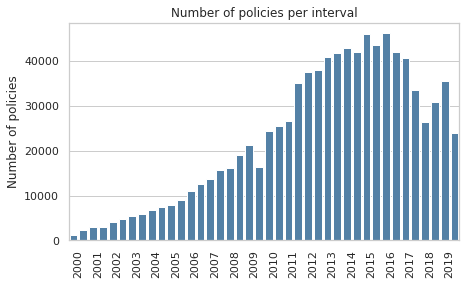

In [45]:
df_2000 = df[df.year>=2000]
plot_policy_counts(df_2000)

# Word counts

In [46]:
word_re = re.compile("\w+")

def get_word_counts(df,y,s):
    ysdf = df[(df["year"]==y) & (df["season"]==s)]
    texts = ysdf.policy_text
    wcs = []
    for text in texts:
        wc = sum((1 for _ in word_re.findall(text)), 0)
        wcs.append(wc)
    return wcs

def get_average_word_count(df,y,s):
    wcs = get_word_counts(df,y,s)
    return np.mean(wcs), np.std(wcs)

In [47]:
 def word_count_boxplot(df):
        
    intervals = get_intervals(df)
    ys_order = ["%d_%s" % i for i in intervals]
    labels = ["%d" % year for year in sorted(set(list(zip(*intervals))[0]))]
    
    chart = sns.boxplot(x="year_season",y="word_count",data=df,showfliers=False,color="steelblue",order=ys_order,boxprops=dict(alpha=.7))
    plt.xticks(np.arange(0,len(intervals),2)+0.5,labels,rotation="vertical")
    
    
    plt.xlabel("")
    plt.ylabel("Word count")
    
    #plt.title("Word count distribution by interval")
    plt.savefig("figures/word_counts.pdf",bbox_inches='tight')
    plt.show()
    

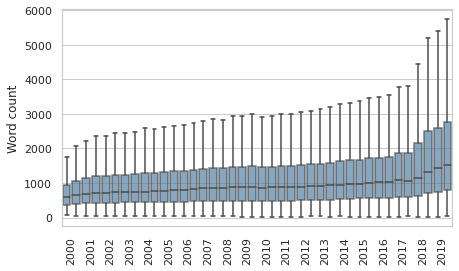

In [48]:
word_count_boxplot(deduped_df[deduped_df.year>=2000])

In [49]:
deduped_df.word_count

237698      110
1043500    1703
892937      810
1118180     917
337273     1026
           ... 
1221991    1694
340360     2873
892528     1285
79317      1598
547901     2479
Name: word_count, Length: 910546, dtype: int64

In [50]:
wcs = list(sorted(list(deduped_df.word_count)))
len(deduped_df.word_count),wcs[int(len(wcs)*.95)],wcs[int(len(wcs)*.05)]

(910546, 3404, 248)

# Character counts

In [51]:
word_re = re.compile("\w+")

def get_character_counts(df,y,s):
    ysdf = df[(df["year"]==y) & (df["season"]==s)]
    texts = ysdf.policy_text
    wcs = []
    for text in texts:
        wc = len(text)#sum((len(word) for word in word_re.findall(text)), 0)
        wcs.append(wc)
    return wcs

def get_average_character_count(df,y,s):
    wcs = get_character_counts(df,y,s)
    return np.mean(wcs), np.std(wcs)

In [52]:
def plot_character_counts(df):

    intervals = get_intervals(df)
    x = list(range(len(intervals)))
    labels = ["%d%s" % interval for interval in intervals]
    
    
    character_avg_stdev = [get_average_character_count(df,y,s) for y,s in intervals]

    averages,stdevs = zip(*character_avg_stdev)

    fig, ax = plt.subplots()


    ax.bar(x, averages, label="Average character count")
    ax.errorbar(x, averages, yerr=stdevs,color="red",ls='none')

    plt.xticks(x,labels,rotation="vertical")
    plt.title("Average character counts per interval")


    plt.show()

In [53]:
def character_count_boxplot(df):

    intervals = get_intervals(df)
    x = list(range(len(intervals)))
    labels = ["%d%s" % interval for interval in intervals]

    # Generate some random indices that we'll use to resample the original data
    # arrays. For code brevity, just use the same random indices for each array
    data = [get_character_counts(df,*interval) for interval in intervals]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    fig.canvas.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5,showfliers=False)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    # Hide these grid behind plot objects
    ax1.set_axisbelow(True)
    ax1.set_title('Distribution of character counts for each interval')
    ax1.set_xlabel('Interval')
    ax1.set_ylabel('Character counts')

    # Now fill the boxes with desired colors
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        box_coords = np.column_stack([boxX, boxY])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor="#1f77b4"))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        medianX = []
        medianY = []
        for j in range(2):
            medianX.append(med.get_xdata()[j])
            medianY.append(med.get_ydata()[j])
            ax1.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='*', markeredgecolor='k')

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    top = 30000#max(max(counts) for counts in data)
    bottom = 1
    #ax1.set_ylim(bottom, top)
    ax1.set_xticklabels(labels,
                        rotation=45, fontsize=8)
    
    #plt.yscale("log")

    plt.show()

In [54]:
 def character_count_boxplot(df):
        
    intervals = get_intervals(df)
    ys_order = ["%d%s" % i for i in intervals]
    labels = ["%d" % year for year in sorted(set(list(zip(*intervals))[0]))]
    
    df['char_count'] = df.policy_text.apply(lambda text: len(text), 0)
    chart = sns.boxplot(x="yearseason",y="char_count",data=df,showfliers=False,color="steelblue",order=ys_order)
    plt.xticks(np.arange(0,len(intervals),2)+0.5,labels,rotation="vertical")
    plt.title("Character count distribution by interval")
    plt.savefig("figures/character_counts.pdf")
    plt.show()
    

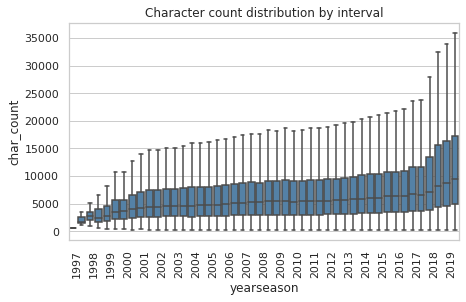

In [55]:
character_count_boxplot(df)

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


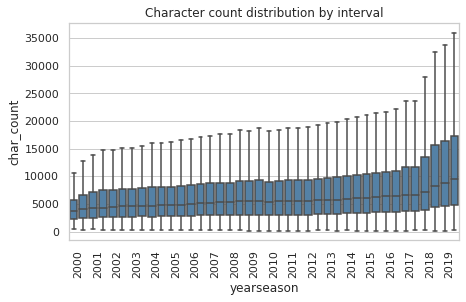

In [56]:
character_count_boxplot(df[df.year>=2000])

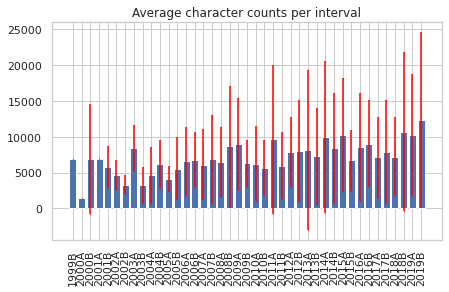

In [57]:
plot_character_counts(sample)

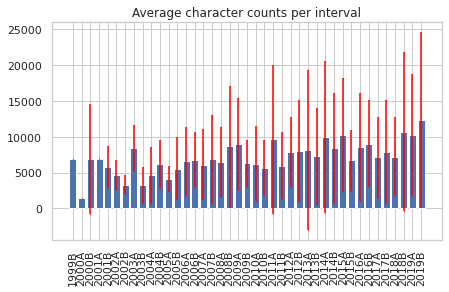

In [58]:
plot_character_counts(sample)

In [59]:
avg_char_2009A = get_average_character_count(df,2009,"A")[0]
avg_char_2019A = get_average_character_count(df,2019,"B")[0]
avg_word_2009A = get_average_word_count(df,2009,"A")[0]
avg_word_2019A = get_average_word_count(df,2019,"B")[0]

In [60]:
print("2009 characters / word: %f" % (avg_char_2009A/avg_word_2009A))
print("2019 characters / word: %f" % (avg_char_2019A/avg_word_2019A))

2009 characters / word: 6.219646
2019 characters / word: 6.255107


In [61]:
char_counts = sum([get_character_counts(df,y,s) for y,s in intervals],[])
word_counts = sum([get_word_counts(df,y,s) for y,s in intervals],[])

In [62]:
scipy.stats.spearmanr(char_counts,word_counts)

SpearmanrResult(correlation=0.998843032461313, pvalue=0.0)

# Readability

In [63]:
from readability import Readability

In [64]:
def get_readability(df,y,s,score_fxn):
    """
    score_fxn should be a lambda that takes the text and gives the readability score
    e.g. lambda text: Readability(text).flesch_kincaid().grade_level
    """
    ysdf = df[(df["year"]==y) & (df["season"]==s)]
    texts = ysdf.policy_text
    readabilities = []
    failed = 0
    for text in texts:
        try:
            readabilities.append(score_fxn(text))
        except:
            failed += 1
    if failed != 0:
        print("Failed to evaluate %d policies for %d%s" % (failed,y,s))
    return np.mean(readabilities), np.std(readabilities)

# def cache_function(func):
#     cache = {}
#     def cached(*args):
#         h = hash(args)
#         if h not in cache:
#             cache[h] = func(*args)
#         return cache[h]
#     return cached

#Scoring functions
fk_score = lambda text: Readability(text).flesch_kincaid().score
f_ease = lambda text: Readability(text).flesch().score
smog_score = lambda text: Readability(text).smog().score

# fk_score_cached = cache_function(fk_score)
# fk_ease_score_cached = cache_function(fk_ease_score)
# smog_score_cached = cache_function(smog_score)



In [65]:
#%%script false --no-raise-error

#Run this to pre-compute scores
def apply_scores(row):
#     try:
#         row["flesch_kincaid"] = fk_score(row.policy_text)
#     except:
#         row["flesch_kincaid"] = None
    try:
        row["flesch_ease"] = f_ease(row.policy_text)
    except:
        row["flesch_ease"] = None
#     try:
#         row["smog"] = smog_score(row.policy_text)
#     except:
#         row["smog"] = None
    return row

df = df.apply(apply_scores,axis=1)

In [66]:
def get_readability_precomputed(df,y,s,score_fxn):
    """
    score_fxn should be a lambda that takes the text and gives the readability score
    e.g. lambda text: Readability(text).flesch_kincaid().grade_level
    """
    ysdf = df[(df["year"]==y) & (df["season"]==s)]
    scores = ysdf[score_fxn]
    readabilities = [s for s in scores if (type(s) == str and s != None) or (type(s) == float and not math.isnan(s))]
    
    return np.mean(readabilities), np.std(readabilities)

#Scoring functions
fk_score_col = "flesch_kincaid"
f_ease_col = "flesch_ease"
smog_score_col = "smog"



get_readability = get_readability_precomputed
fk_score = fk_score_col
f_ease = f_ease_col
smog_score = smog_score_col

In [67]:
def plot_flesch_kincaid(df,title_suffix=""):
    
    
    #General plot things
    intervals = get_intervals(df)
    x = list(range(len(intervals)))
    labels = ["%d%s" % interval for interval in intervals]
    
    avg_std_fk = [get_readability(df,y,s,fk_score) for y,s in intervals]
    averages,stdevs = zip(*avg_std_fk)

    fig, ax = plt.subplots()


    ax.bar(x, averages, label="Average word count")
    ax.errorbar(x, averages, yerr=stdevs,color="red",ls='none')

    plt.xticks(x,labels,rotation="vertical")
    plt.title("Average Flesch-Kincaid Score per interval%s" % title_suffix)
    plt.ylabel("Average grade level")
    plt.xlabel("Interval")

    plt.show()
    
def plot_smog(df,title_suffix=""):
    #General plot things
    intervals = get_intervals(df)
    x = list(range(len(intervals)))
    labels = ["%d%s" % interval for interval in intervals]
    
    
    avg_std_smog = [get_readability(df,y,s,smog_score) for y,s in intervals]
    averages,stdevs = zip(*avg_std_smog)

    fig, ax = plt.subplots()


    ax.bar(x, averages, label="Average word count")
    ax.errorbar(x, averages, yerr=stdevs,color="red",ls='none')

    plt.xticks(x,labels,rotation="vertical")
    plt.title("Average Smog Score per interval%s" % title_suffix)
    plt.ylabel("Average grade level")
    plt.xlabel("Interval")

    plt.show()

In [68]:
ease_ordering = ["very_easy", "easy", "fairly_easy", "standard",
                 "fairly_difficult", "difficult", "very_confusing", None]
    
def plot_flesch_ease(df,title_suffix=""):
    
    intervals = get_intervals(df)
    
    x = list(range(len(intervals)))
    labels = ["%d%s" % interval for interval in intervals]

    fig, ax = plt.subplots()
    
    
    interval_dfs = (df[(df.year==y) & (df.season==s)] for y,s in intervals)
    all_ease_counts = (len(d) for d in interval_dfs)
    all_ease_counts = list(all_ease_counts)
    
    prev_y = np.zeros(len(intervals))
    for ease in ease_ordering:
        
        #Count
        interval_dfs = (df[(df.year==y) & (df.season==s)] for y,s in intervals)
        if ease is None:
            ease_hits = (d[d.flesch_ease.isnull()] for d in interval_dfs)
        else:
            ease_hits = (d[d.flesch_ease == ease] for d in interval_dfs)
        ease_count = (len(hits) for hits in ease_hits)
        #Normalize
        ease_count = (count / total for count,total in zip(ease_count,all_ease_counts))
        
        #Save to list
        ease_count = np.array(list(ease_count))
        
        #Plot
        if ease is None:
            ease_label = "None"
        else:
            ease_label = ease
        plt.bar(x,ease_count,bottom=prev_y,label=ease_label)
        prev_y += ease_count

    plt.xticks(x,labels,rotation="vertical")
    plt.ylabel("Proportion")
    plt.xlabel("Interval")
    plt.title("Flesch ease score count per interval%s" % title_suffix)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    handles, labels = zip(*reversed(list(zip(handles,labels))[3:]))
    
    plt.legend(handles,labels)

    plt.show()

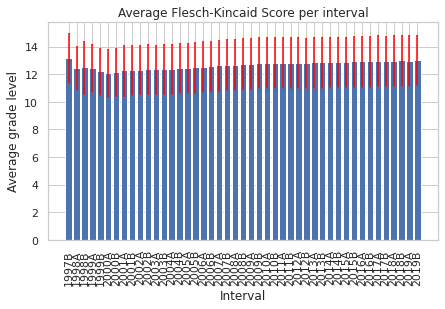

In [69]:
plot_flesch_kincaid(df[df.flesch_kincaid < 20])

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the futur

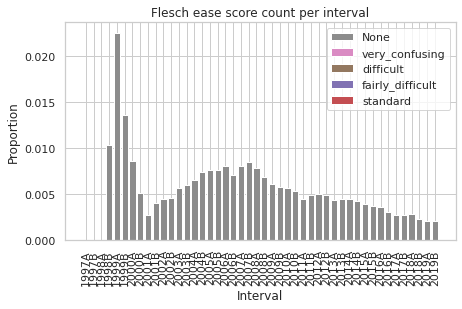

In [70]:
plot_flesch_ease(df)

In [71]:
sns.distplot("flesch_ease",data=df)

TypeError: distplot() got an unexpected keyword argument 'data'

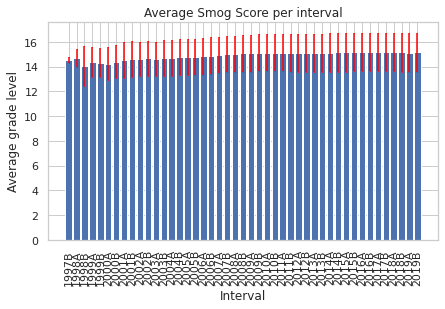

In [72]:
plot_smog(df[df.smog < 20])

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the futur

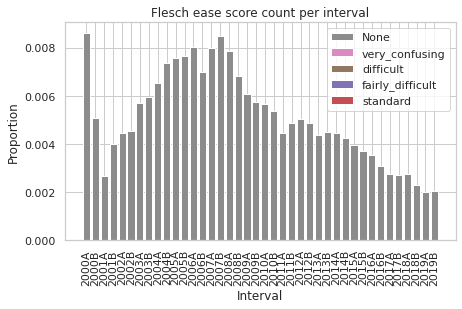

In [73]:
plot_flesch_ease(df[df.year>=2000])

In [74]:
df_s = df[df.flesch_kincaid.notnull() & (df.flesch_kincaid > 17)].sort_values("flesch_kincaid",axis=0)
df_s[["flesch_kincaid","site_url","year","season"]]

,flesch_kincaid,site_url,year,season
136822,17.000017,http://zerista.com,2009,B
430378,17.000500,http://zenodo.org,2017,B
430381,17.000500,http://zenodo.org,2018,A
430383,17.000500,http://zenodo.org,2018,B
430382,17.000500,http://zenodo.org,2019,B
...,...,...,...,...
327877,32.613686,http://nichebot.com,2007,B
576456,32.789949,http://talkingdata.com,2017,B
576455,32.789949,http://talkingdata.com,2017,A
576460,34.052522,http://talkingdata.com,2015,B


In [75]:
ease_ordering = ["very_easy", "easy", "fairly_easy", "standard",
                 "fairly_difficult", "difficult", "very_confusing", None]

tab10 = plt.cm.get_cmap("tab10")

ease_color = [tab10(1.0),tab10(1.0),tab10(1.0),tab10(1.0),tab10(0/8),tab10(1/8),tab10(2/8),tab10(6/8)]
    
def plot_flesch_ease_flat(df,title_suffix=""):
    
    sns.set_style("white")
    
    
    
    plt.figure(figsize=(7,0.5))
    
    df = df[df.year_season == "2019_B"]
    
    intervals = get_intervals(df)
    
    x = list(range(len(intervals)))
    labels = ["%d%s" % interval for interval in intervals]

    
    
    interval_dfs = (df[(df.year==y) & (df.season==s)] for y,s in intervals)
    all_ease_counts = (len(d) for d in interval_dfs)
    all_ease_counts = list(all_ease_counts)
    
    prev_y = np.ones(len(intervals))
    
    for ease,color in reversed(list(zip(ease_ordering,ease_color))):
        
        #Count
        interval_dfs = (df[(df.year==y) & (df.season==s)] for y,s in intervals)
        if ease is None:
            ease_hits = (d[d.flesch_ease.isnull()] for d in interval_dfs)
        else:
            ease_hits = (d[d.flesch_ease == ease] for d in interval_dfs)
        ease_count = (len(hits) for hits in ease_hits)
        #Normalize
        ease_count = (count / total for count,total in zip(ease_count,all_ease_counts))
        
        #Save to list
        ease_count = np.array(list(ease_count))
        
        #Plot
        if ease is None:
            ease_label = "None"
        else:
            ease_label = ease
        #plt.bar(x,ease_count,bottom=prev_y,label=ease_label)
        fig = sns.barplot(prev_y,x,label=ease_label,color=color,orient="h")
        prev_y -= ease_count

        
    
        
    
    handles, labels = fig.get_legend_handles_labels()
    fig.legend(handles, labels)
    handles, labels = zip(*reversed(list(zip(handles,labels))[:5]))
    labels = ("Easy/Standard","Fairly Difficult", "Difficult", "Very confusing","None")
    
    order = [0,3,1,4,2]
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    
    plt.legend(handles,labels,bbox_to_anchor=(0,-.7),loc="upper left",ncol=3)
    #plt.legend()
    sns.despine(left=True,bottom=True)
    plt.show()
    sns.set_style("whitegrid")
    
    fig.get_figure().savefig("figures/flesch_ease.pdf", bbox_inches='tight')

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an ex

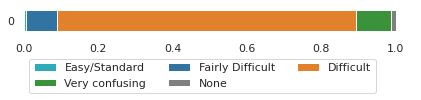

In [76]:
plot_flesch_ease_flat(deduped_df)

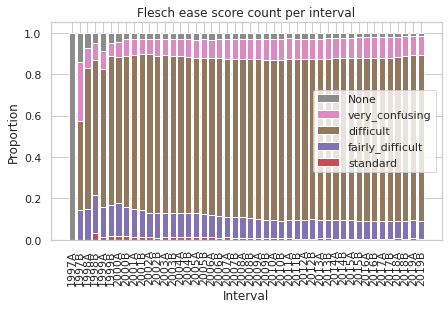

In [77]:
plot_flesch_ease(deduped_df)

In [78]:
 def flesch_kincaid_boxplot(df):
        
    plt.figure(figsize=(7,3))
        
    intervals = get_intervals(df)
    ys_order = ["%d_%s" % i for i in intervals]
    labels = ["%d" % year for year in sorted(set(list(zip(*intervals))[0]))]
    
    chart = sns.boxplot(x="year_season",y="flesch_kincaid",data=df,showfliers=False,color="steelblue",order=ys_order,boxprops=dict(alpha=.7))
    plt.xticks(np.arange(0,len(intervals),2)+0.5,labels,rotation="vertical")
    
    
    plt.xlabel("")
    plt.ylabel("Flesch Kincaid Grade Level")
    
    plt.yticks(np.arange(8,19))
    
    #plt.title("Word count distribution by interval")
    plt.savefig("figures/flesch_kincaid.pdf",bbox_inches='tight')
    plt.show()
    

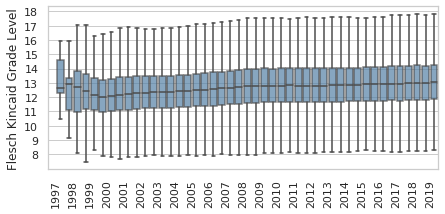

In [79]:
flesch_kincaid_boxplot(deduped_df)

# Stratified

In [80]:
import historical.alexa as alexa
alexa.load()

In [81]:
df_1k = df[df.apply(lambda s: alexa.get_alexa_rank(s.year,s.season,s.site_url,default_rank=1000001) <= 1000, axis=1)]

In [82]:
df_1k

,site_url,year,season,policy_text,policy_snapshot_url,policy_filetype,raw_source_path,link_text,homepage_snapshot_url,homepage_snapshot_redirected_url,...,homepage_snapshot_domain,homepage_snapshot_redirected_domain,parked_domain,classifier_probability,alexa_rank,cross_domain_homepage_redir,redirected_to_similar_domain,cross_domain_policy,yearseason,char_count
336829,http://meetup.com,2015,B,"Revision date: May 23, 2010 \n\nBelow is our o...",https://web.archive.org/web/20151231193203id_/...,html,crawl2/data-18/out/policy_html/10273_2015_B_20...,Privacy & Terms,https://web.archive.org/web/20151001115243id_/...,https://web.archive.org/web/20151001115243id_/...,...,meetup.com,meetup.com,False,0.958718,430.0,False,True,0,2015B,11290
90410,http://cbc.ca,2015,B,The CBC Privacy Coordinator is accountable for...,https://web.archive.org/web/20151231114244id_/...,html,crawl7/data-03/out/policy_html/388_2015_B_2015...,Privacy Policy,https://web.archive.org/web/20150930233053id_/...,https://web.archive.org/web/20150930233053id_/...,...,cbc.ca,cbc.ca,False,0.956240,864.0,False,True,0,2015B,13682
458080,http://woot.com,2015,B,We gave in and let the lawyers work over our p...,https://web.archive.org/web/20150915161557id_/...,html,crawl1/data-31/out/policy_html/10402_2015_B_20...,Privacy Policy,https://web.archive.org/web/20150927215143id_/...,https://web.archive.org/web/20150927215143id_/...,...,woot.com,woot.com,False,0.993120,628.0,False,True,0,2015B,2290
948803,http://homedepot.com,2015,B,The Home Depot values and respects the privacy...,https://web.archive.org/web/20151231140540id_/...,html,crawl1/data-13/out/policy_html/14190_2015_B_20...,Privacy & Security Statement,https://web.archive.org/web/20151001152919id_/...,https://web.archive.org/web/20151001152919id_/...,...,homedepot.com,homedepot.com,False,0.957522,226.0,False,True,0,2015B,23553
857709,http://justdial.com,2015,B,### Privacy Policy\n\nIn the course of regist...,https://web.archive.org/web/20151122071241id_/...,html,crawl1/data-16/out/policy_html/874_2015_B_2015...,Privacy,https://web.archive.org/web/20151009013148id_/...,https://web.archive.org/web/20151009013148id_/...,...,justdial.com,justdial.com,False,0.943750,492.0,False,True,0,2015B,4738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118579,http://coupons.com,2013,A,\n\nThis Privacy Policy is effective as of Oc...,https://web.archive.org/web/20130617015021id_/...,html,crawl1/data-07/out/policy_html/7825_2013_A_201...,Privacy Policy,https://web.archive.org/web/20130401160800id_/...,https://web.archive.org/web/20130401160800id_/...,...,coupons.com,coupons.com,False,0.991018,890.0,False,True,1,2013A,20703
479459,http://verizonwireless.com,2014,B,### Verizon is Committed to Protecting Your P...,https://web.archive.org/web/20141231080456id_/...,html,crawl1/data-30/out/policy_html/5975_2014_B_201...,Privacy,https://web.archive.org/web/20141001014836id_/...,https://web.archive.org/web/20141001014836id_/...,...,verizonwireless.com,verizonwireless.com,False,0.937773,440.0,False,True,1,2014B,6349
373163,http://espnfc.com,2013,A,"This policy tells you how ESPN (EUROPE, MIDDLE...",https://web.archive.org/web/20130120030521id_/...,html,crawl2/data-10/out/policy_html/2919_2013_A_201...,Privacy Policy and Safety Information/Your Cal...,https://web.archive.org/web/20130401070432id_/...,https://web.archive.org/web/20130401070432id_/...,...,espnfc.com,espnfc.com,False,0.992538,836.0,False,True,1,2013A,10080
607299,http://sourceforge.net,2013,A,PRIVACY STATEMENT • SLASHDOT MEDIA\n\nLAST UPD...,https://web.archive.org/web/20130529020441id_/...,html,crawl1/data-26/out/policy_html/10545_2013_A_20...,Privacy,https://web.archive.org/web/20130401005807id_/...,https://web.archive.org/web/20130401005807id_/...,...,sourceforge.net,sourceforge.net,False,0.971368,175.0,False,True,1,2013A,31989


In [83]:
def plot_flesch_kincaid_double(df_1k,df):
    
    
    #General plot things
    intervals = get_intervals(df_1k)
    x = np.arange(len(intervals))
    labels = ["%d%s" % interval for interval in intervals]

    fig, ax = plt.subplots()
    
    avg_std_fk = [get_readability(df,y,s,fk_score) for y,s in intervals]
    averages,stdevs = zip(*avg_std_fk)

    width = 0.35
    
    ax.bar(x-width/2, averages, label="All domains",width=width,align="center")
    ax.errorbar(x-width/2, averages, yerr=stdevs,color="red",ls='none')
    
    
    
    avg_std_fk = [get_readability(df_1k,y,s,fk_score) for y,s in intervals]
    averages,stdevs = zip(*avg_std_fk)

    ax.bar(x+width/2, averages, label="Top 1k domains",width=width,align="center")
    ax.errorbar(x+width/2, averages, yerr=stdevs,color="red",ls='none')
    
    

    plt.xticks(x,labels,rotation="vertical")
    plt.title("Average Flesch-Kincaid Score per interval")
    plt.ylabel("Average grade level")
    plt.xlabel("Interval")
    
    plt.legend(loc=(0.75, 0.5))

    plt.show()
    
def plot_smog_double(df_1k,df):
    #General plot things
    intervals = get_intervals(df_1k)
    x = np.arange(len(intervals))
    labels = ["%d%s" % interval for interval in intervals]

    width = 0.35
    
    fig, ax = plt.subplots()
    
    avg_std_fk = [get_readability(df,y,s,smog_score) for y,s in intervals]
    averages,stdevs = zip(*avg_std_fk)

    ax.plot(x, averages, label="All domains",color="steelblue")
    #ax.errorbar(x-width/2, averages, yerr=stdevs,color="red",ls='none')
    
    
    
    avg_std_fk = [get_readability(df_1k,y,s,smog_score) for y,s in intervals]
    averages,stdevs = zip(*avg_std_fk)

    ax.plot(x, averages, label="Top 1k domains",color="coral")
    #ax.errorbar(x+width/2, averages, yerr=stdevs,color="red",ls='none')
    
    
    plt.ylim(0,17)
    
    plt.xticks(x,labels,rotation="vertical")
    plt.title("Average Smog Score per interval")
    plt.ylabel("Average grade level")
    plt.xlabel("Interval")
    
    plt.legend(loc=(0.75, 0.5))

    plt.show()

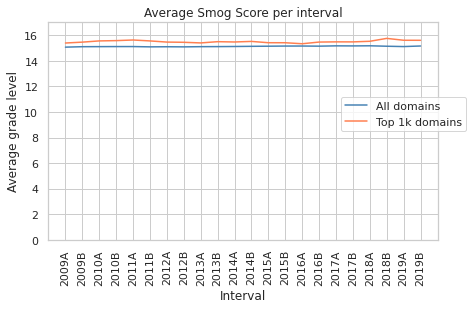

In [84]:
plot_smog_double(df_1k[df_1k.smog<20],df[df.smog<20])

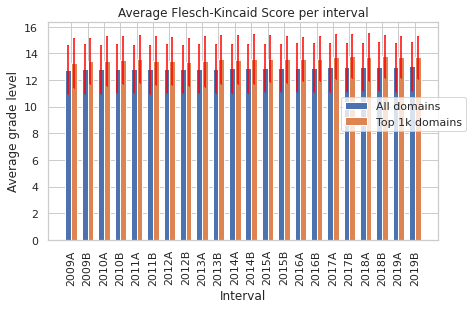

In [85]:
plot_flesch_kincaid_double(df_1k[df_1k.flesch_kincaid<20],df[df.flesch_kincaid<20])

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the futur

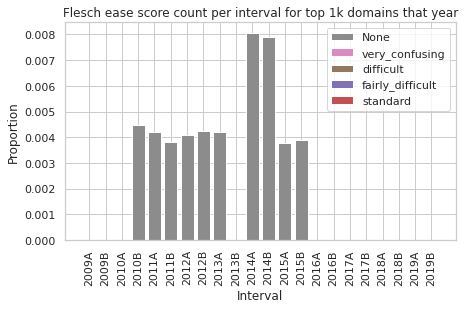

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the futur

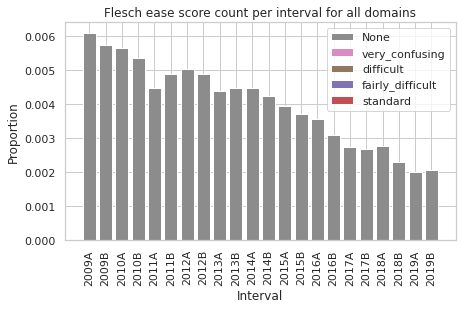

In [86]:
plot_flesch_ease(df_1k,title_suffix=" for top 1k domains that year")
plot_flesch_ease(df[df.year >= 2009],title_suffix=" for all domains")

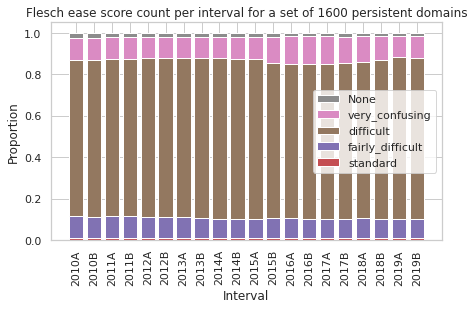

In [87]:

plot_flesch_ease(df_persistent,title_suffix=" for a set of 1600 persistent domains")

In [88]:
len(set(df_persistent.site_url))

1192

In [89]:
len(df_persistent)

23840

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


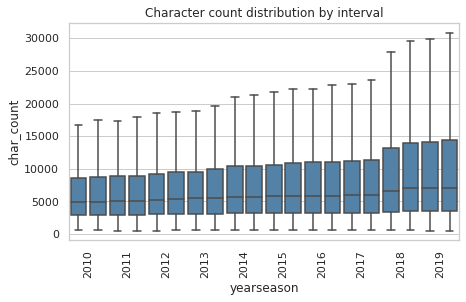

In [90]:
character_count_boxplot(df_persistent)

# Polices and snapshots graph

In [149]:
#with open("/n/fs/privpolicy/data/wayback_crawls/top_100K_1996-2019/en_snapshots_df.pickle", "rb") as f:
    #en_snapshots_df = pd.read_pickle(f)
    
en_snapshots_df = pd.read_pickle("/n/fs/privpolicy/data/wayback_crawls/top_100K_1996-2019/en_snapshots_df_deduped.pickle")

In [150]:
print(list(en_snapshots_df))

['domain', 'year_season', 'alexa_rank', 'site_interval', 'downloaded']


In [155]:
def set_x_ticks(df):
    unique_intervals = df['interval'].unique()
    num_intervals = len(unique_intervals)
    unique_years = sorted(set([int(interval.split("_")[0]) for interval in unique_intervals]))
    plt.xticks(np.arange(0, num_intervals, 2)+0.5, unique_years, rotation=90)

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


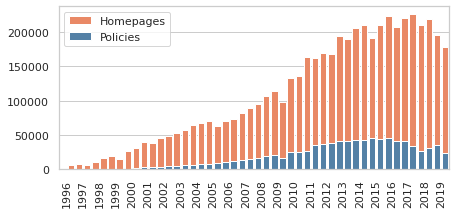

In [156]:
df_ss = en_snapshots_df.groupby("year_season").size().to_frame(name="count")
df_ss["interval"] = df_ss.index

order = list(sorted(df_ss.interval))

sns.barplot("interval","count", data=df_ss,color="coral",label="Homepages",order=order)


df_pol = en_snapshots_df[en_snapshots_df.downloaded].groupby("year_season").size().to_frame(name="count")
df_pol["interval"] = df_pol.index
fig = sns.barplot("interval","count", data=df_pol,color="steelblue",label="Policies",order=order)

plt.ylabel("")
plt.xlabel("")

plt.legend(loc='upper left')

set_x_ticks(df_ss)

plt.savefig("figures/policy_homepage_counts.pdf",bbox_inches='tight')

In [132]:
def plot_snapshots_dist(df):
    sns.barplot(x="year_season", data=en_snapshots_df)

In [133]:
plot_snapshots_dist(en_snapshots_df)

TypeError: Horizontal orientation requires numeric `x` variable.

In [134]:
del en_snapshots_df

# Readability p2

In [5]:
import nb_trending
import importlib
importlib.reload(nb_trending)

<module 'nb_trending' from '/n/fs/policyphylog/PrivacyPolicyPlagiarism/notebooks/nb_trending.py'>

In [6]:
nb_trending.add_rank_bins_to_df(df)

In [7]:
df = df.sort_values("year_season")

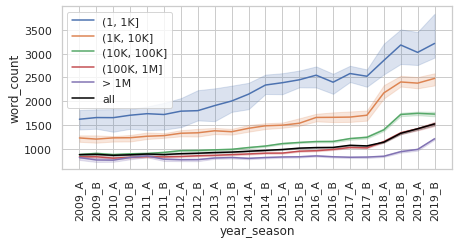

In [22]:
plt.figure(figsize=(7,3))
sns.lineplot(x="year_season",y="word_count",hue="binned_rank",data=df[df.year >= 2009], estimator=np.median,ci=95,hue_order=nb_trending.RANK_BIN_LABELS)
fig = sns.lineplot(x="year_season",y="word_count",data=df[df.year >= 2009], estimator=np.median,ci=95,label="all",color="black")
plt.xticks(rotation=90)
pass

<AxesSubplot:xlabel='year_season', ylabel='flesch_kincaid'>

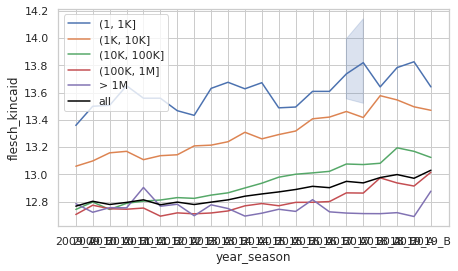

In [13]:
plt.figure(figsize=(7,4))

sns.lineplot(x="year_season",y="flesch_kincaid",hue="binned_rank",data=df[df.year >= 2009], estimator=np.median,ci=95,hue_order=nb_trending.RANK_BIN_LABELS)
sns.lineplot(x="year_season",y="flesch_kincaid",data=df[df.year >= 2009], estimator=np.median,ci=95,label="all",color="black")

<Figure size 504x288 with 0 Axes>

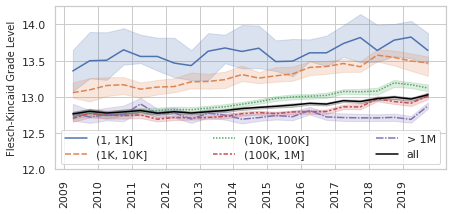

In [8]:
hue="binned_rank"
start_year=2009

plt.figure(figsize=(7,4))

fig = nb_trending.lineplot_per_interval(df[df.flesch_kincaid.notnull()], y='flesch_kincaid', hue=hue, y_title="Flesch-Kincaid Grade Level",
        start_year=start_year, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=nb_trending.RANK_BIN_LABELS)

sns.lineplot(x="year_season",y="flesch_kincaid",data=df[(df.year >= 2009) & df.flesch_kincaid.notnull()], estimator=np.median,ci=95,label="all",color="black")

plt.ylim(12,14.25)
handles,figlabels = fig.get_legend_handles_labels()
plt.legend(handles=handles, labels=figlabels,mode="expand",ncol=3,loc="lower left")
plt.xlabel("")
nb_trending.save_figure(fig,"flesch_kincaid_dist.pdf")

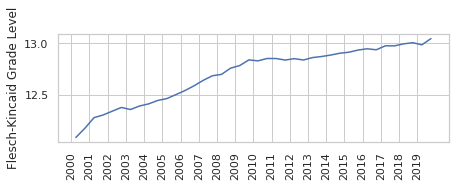

In [15]:

plt.figure(figsize=(7,2))

df_2k = df[df.year>=2000]
fig = sns.lineplot(data=df_2k, y="flesch_kincaid", x=nb_trending.INTERVAL_COL_NAME,legend=False)
nb_trending.set_x_ticks(df_2k)
#plt.ylim(12,14.25)
plt.ylabel("Flesch-Kincaid Grade Level")
plt.xlabel("")
nb_trending.save_figure(fig,"flesch_kincaid.pdf")

<Figure size 504x216 with 0 Axes>

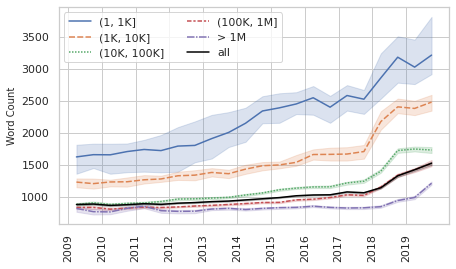

In [9]:
hue="binned_rank"
start_year=2009

plt.figure(figsize=(7,3))

fig = nb_trending.lineplot_per_interval(df, y='word_count', hue=hue, y_title="Word Count",
        start_year=start_year, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=nb_trending.RANK_BIN_LABELS)


sns.lineplot(x="year_season",y="word_count",data=df[df.year >= 2009], estimator=np.median,ci=95,label="all",color="black")

handles,figlabels = fig.get_legend_handles_labels()
plt.legend(handles=handles, labels=figlabels,ncol=2,loc="upper left")
plt.xlabel("")
nb_trending.save_figure(fig,"word-count-by-rank.pdf")

<Figure size 504x216 with 0 Axes>

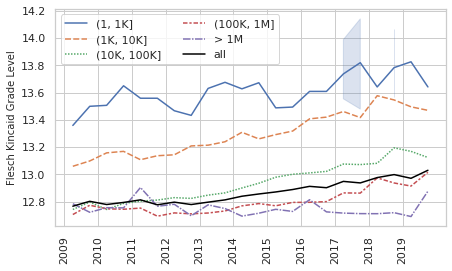

In [18]:
hue="binned_rank"
start_year=2009

plt.figure(figsize=(7,3))

fig = nb_trending.lineplot_per_interval(df, y='flesch_kincaid', hue=hue, y_title="Flesch Kincaid Grade Level",
        start_year=start_year, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=nb_trending.RANK_BIN_LABELS)

sns.lineplot(x="year_season",y="flesch_kincaid",data=df[df.year >= 2009], estimator=np.median,ci=95,label="all",color="black")



handles,figlabels = fig.get_legend_handles_labels()
plt.legend(handles=handles, labels=figlabels,ncol=2,loc="upper left")
plt.xlabel("")
nb_trending.save_figure(fig,"flesch_kincaid.pdf")

In [162]:
df[df.year_season == "2000_A"].flesch_kincaid.median(),df[df.year_season == "2019_B"].flesch_kincaid.median()

(11.941815018315019, 13.2350414389682)

In [161]:
df[df.year_season == "2000_A"].word_count.mean(),df[df.year_season == "2019_B"].word_count.mean()

(772.9327599687256, 2379.084928152587)

# Binned Rank abundance

In [ ]:
list(df)

In [ ]:

order = list(sorted(df.interval.u))
fig = sns.barplot("interval","count", data=df,color="steelblue",label="Policies",order=order)
fig = sns.barplot("interval","count", data=df[df.rank<1000000],color="steelblue",label="Policies",order=order)

In [ ]:
deduped_df[deduped_df.year_season == "2019_B"].word_count.median()